# Imports & Globals

In [1]:
import numpy as np
import pandas as pd
import datetime
from yaml import safe_load
import tensorflow as tf

In [2]:
from SiameseModel import CosineDistance, ContrastiveLoss, get_model, plt_metric 

tf.version:  2.9.1
tf.keras.version:  2.9.0
tf.config.devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-21 12:41:45.015537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:41:45.038632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:41:45.038780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:41:45.040095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [3]:
%matplotlib inline

In [4]:
with open('LSTM65.yaml', 'r') as file:
    model_config = safe_load(file)

# Load data from csv

In [5]:
train = pd.read_pickle("../data/proccesed_train_set.pkl")
x1TrainRnnS, x2TrainRnnS = train[["x1", "x2"]].applymap(lambda x: np.asarray(x).astype('float32')).values.T
yTrainRnnS = train["y"].astype('float32')
print(train["y"].value_counts(ascending=True))
del train

test = pd.read_pickle("../data/proccesed_test_set.pkl")
x1ValRnnS, x2ValRnnS = test[["x1", "x2"]].applymap(lambda x: np.asarray(x).astype('float32')).values.T
yValRnnS = test["y"].astype('float32')
print(test["y"].value_counts(ascending=True))
del test

0    710763
1    719739
Name: y, dtype: int64
0    473402
1    480267
Name: y, dtype: int64


--------------------------------

# Build model, load weights and evaluate on test data

In [6]:
learning_rate = model_config['Learning_Rate']

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps=2000,
    decay_rate=0.75,
    staircase=True
)

model = get_model(
    model_type =  model_config['Model_Type'], 
    maxlen =  model_config['MAXLEN'],
    embedding_dim = model_config['Embedding_Dimensions'], 
    num_rnn_node =  model_config['Number_RNN_Nodes'],
    bidirectional = model_config['Bidirectional'],
    num_dense_node =  model_config['Number_Dense_Nodes'], 
    num_layer =  model_config['Number_Layers'], 
    activation_fn =  model_config['Activation_Function'],
    learning_rate = lr_schedule,
    optimizer_fn = model_config['Optimizer'],
    margin =  model_config['Margin'],
    output_activation = model_config['Output_Activation'],
    random_seed = model_config['Random_Seed']
)
model.summary()

2022-10-21 12:42:14.399609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:42:14.400060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:42:14.400219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:42:14.400382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 12:42:14.400518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model (Functional)             (None, 65)           76425       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [7]:
EPOCHS = 100
time = datetime.datetime.now()
checkpoint_filepath = "../ModelCheckpointSaves/maxlen-{}/{}/{}/{}".format(model_config['MAXLEN'], model_config["Model_Name"], time.strftime("%a-%b-%d-%Y"), time.strftime("%I-%M%p"))
print(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=10, min_delta = 0.00005, restore_best_weights = True)

../ModelCheckpointSaves/maxlen-65/BEST_LSTM65/Fri-Oct-21-2022/12-42PM


In [8]:
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(
    x=[np.stack(x1TrainRnnS), np.stack(x2TrainRnnS)],
    y=np.stack(yTrainRnnS),
    epochs=EPOCHS,
    batch_size=800,
    shuffle=True,
    validation_data=([np.stack(x1ValRnnS), np.stack(x2ValRnnS)], np.stack(yValRnnS)),
    callbacks=[model_checkpoint_callback, early_stopping],
    use_multiprocessing=True
)

Epoch 1/100


2022-10-21 12:42:22.134990: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-10-21 12:42:29.109580: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f74d8003950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-21 12:42:29.109607: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2022-10-21 12:42:29.115180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR cras

1789/1789 [==============================] - 53s 24ms/step - loss: 0.0965 - accuracy: 0.9152 - val_loss: 0.0490 - val_accuracy: 0.9455
Epoch 2/100
1789/1789 [==============================] - 42s 24ms/step - loss: 0.0317 - accuracy: 0.9638 - val_loss: 0.0348 - val_accuracy: 0.9573
Epoch 3/100
1789/1789 [==============================] - 41s 23ms/step - loss: 0.0221 - accuracy: 0.9730 - val_loss: 0.0310 - val_accuracy: 0.9599
Epoch 4/100
1789/1789 [==============================] - 42s 23ms/step - loss: 0.0180 - accuracy: 0.9774 - val_loss: 0.0293 - val_accuracy: 0.9616
Epoch 5/100
1789/1789 [==============================] - 41s 23ms/step - loss: 0.0154 - accuracy: 0.9804 - val_loss: 0.0264 - val_accuracy: 0.9651
Epoch 6/100
1789/1789 [==============================] - 41s 23ms/step - loss: 0.0138 - accuracy: 0.9826 - val_loss: 0.0285 - val_accuracy: 0.9626
Epoch 7/100
1789/1789 [==============================] - 41s 23ms/step - loss: 0.0125 - accuracy: 0.9843 - val_loss: 0.0286 - val_

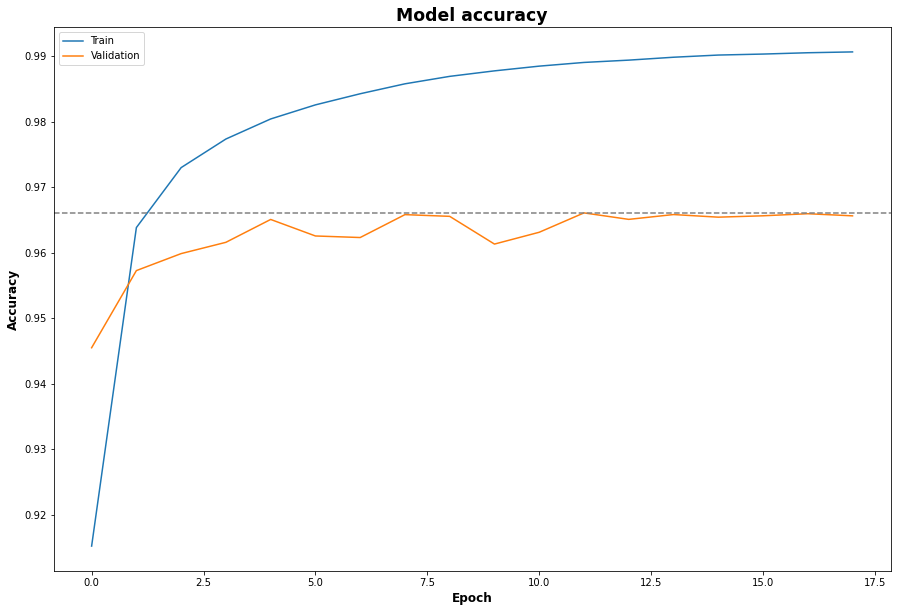

In [9]:
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

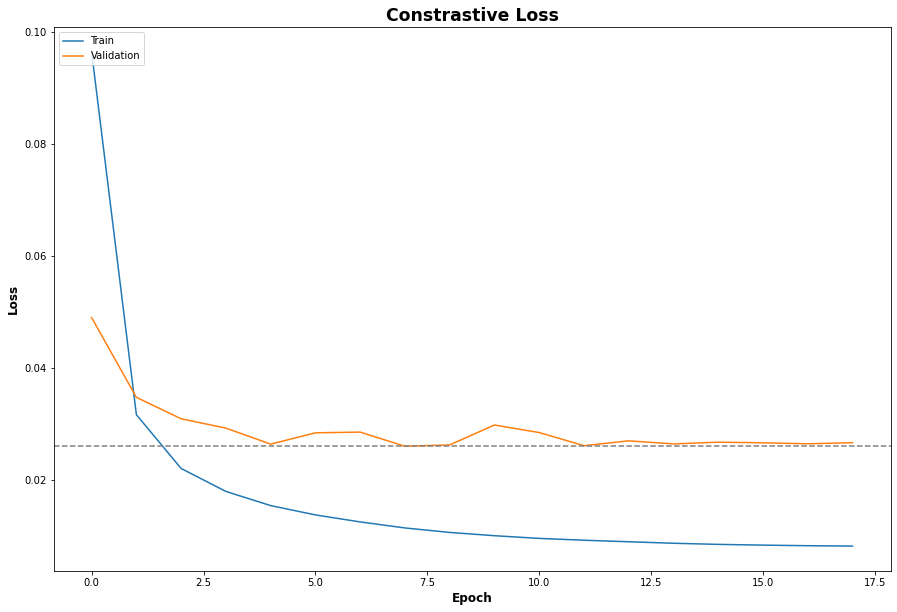

In [10]:
# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [11]:
print("Max Validation Accuracy: ", max(history.history["val_accuracy"]))
print("Min Validation Loss: ", min(history.history["val_loss"]))

Max Validation Accuracy:  0.9660877585411072
Min Validation Loss:  0.026048539206385612


In [12]:
save = input("Want to replace best model with this model? (y/n): ")

if save.lower() == "y":
    tf.keras.models.save_model(model, './saved_models/{}'.format(model_config["Model_Name"]))

Want to replace best model with this model? (y/n): y


INFO:tensorflow:Assets written to: ./saved_models/BEST_LSTM65/assets


INFO:tensorflow:Assets written to: ./saved_models/BEST_LSTM65/assets
